In [1]:
from __future__ import annotations

import os
import sqlite3
import tempfile
import time
from typing import Annotated, Any, Dict, Optional, TypedDict

from dotenv import load_dotenv
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.vectorstores import FAISS
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage
from langchain_core.tools import tool

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_groq import ChatGroq
import requests

In [2]:
load_dotenv()
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    timeout=60,
    max_retries=3,
)
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [3]:
response=llm.invoke("What is the capital of Germany?")
print(response.content)

The capital of Germany is Berlin.


In [4]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

len(docs)

392

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [6]:
len(chunks)

973

In [7]:
vector_store = FAISS.from_documents(chunks, embeddings)
vector_store

In [8]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})
# retriever.invoke("What is Kernelized Support Vector Machines?")

In [9]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    try:
        
        result = retriever.invoke(query)

        context = [doc.page_content for doc in result]
        metadata = [doc.metadata for doc in result]

        return {
            'query': query,
            'context': context,
            'metadata': metadata,
            'success': True
        }
    except Exception as e:
        return {
            'query': query,
            'error': str(e),
            'success': False
        }

@tool
def web_search_tool(query: str) -> dict:
    """
    Search the web for current information using DuckDuckGo.
    Use this for recent news, events, or information not in documents.
    """
    try:
        search = DuckDuckGoSearchRun(region="us-en")
        result = search.run(query)
        return {
            'query': query,
            'result': result,
            'success': True
        }
    except Exception as e:
        return {
            'query': query,
            'error': str(e),
            'success': False
        }

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed", "success": False}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'", "success": False}

        return {
            "first_num": first_num,
            "second_num": second_num,
            "operation": operation,
            "result": result,
            "success": True
        }
    except Exception as e:
        return {"error": str(e), "success": False}


@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g., 'AAPL', 'MSFT', 'TSLA')
    using Alpha Vantage API.
    """
    try:
        url = (
            "https://www.alphavantage.co/query"
            f"?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
        )
        r = requests.get(url, timeout=10)
        data = r.json()
        
        if "Global Quote" in data and data["Global Quote"]:
            return {
                "symbol": symbol,
                "data": data["Global Quote"],
                "success": True
            }
        else:
            return {
                "symbol": symbol,
                "error": "No data available or invalid symbol",
                "raw_response": data,
                "success": False
            }
    except Exception as e:
        return {"symbol": symbol, "error": str(e), "success": False}

In [10]:
tools = [rag_tool, calculator, get_stock_price, web_search_tool]
llm_with_tools = llm.bind_tools(tools)


In [11]:
# -------------------
# 4. State
# -------------------
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    retry_count: int
    error_log: list

In [12]:
# -------------------
# 5. Nodes
# -------------------
def chat_node(state: ChatState, config=None):
    """LLM node with error handling and retry logic."""
    retry_count = state.get("retry_count", 0)
    error_log = state.get("error_log", [])
    
    system_message = SystemMessage(
        content=(
            "You are a helpful assistant with access to multiple tools. "
            "Use the appropriate tool for each part of the user's question:\n"
            "- Use 'rag_tool' for questions about the uploaded PDF document\n"
            "- Use 'web_search_tool' for current news, events, or web information\n"
            "- Use 'calculator' for mathematical operations\n"
            "- Use 'get_stock_price' for stock market data\n\n"
            "Call tools one at a time when possible to avoid rate limits. "
            "If a tool fails, acknowledge it and continue with other tasks."
        )
    )

    messages = [system_message, *state["messages"]]
    
    try:
        response = llm_with_tools.invoke(messages, config=config)
        return {
            "messages": [response],
            "retry_count": 0,
            "error_log": error_log
        }
    except Exception as e:
        error_msg = f"Error in chat_node (attempt {retry_count + 1}): {str(e)}"
        error_log.append(error_msg)
        print(error_msg)
        
        if retry_count < 3:
            # Wait before retry with exponential backoff
            time.sleep(2 ** retry_count)
            return {
                "messages": state["messages"],
                "retry_count": retry_count + 1,
                "error_log": error_log
            }
        else:
            # Max retries reached, return error message
            error_response = AIMessage(
                content=f"I apologize, but I'm experiencing technical difficulties. "
                        f"Error: {str(e)}. Please try again in a moment."
            )
            return {
                "messages": [error_response],
                "retry_count": 0,
                "error_log": error_log
            }

In [13]:
tool_node = ToolNode(tools)

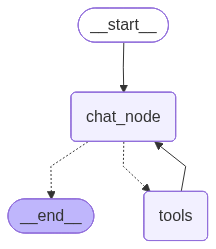

In [14]:
# -------------------
# 7. Graph
# -------------------
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node", tools_condition)
graph.add_edge("tools", "chat_node")

chatbot = graph.compile()
chatbot

In [15]:
# result = chatbot.invoke(
#     {
#         "messages": [
#             HumanMessage(
#                 content=(
#                     "What is Kernelized Support Vector Machines, summarize it briefly in a bullet points.. and then tell me what is the latest stock price of MFST?"
#                     "Also search the web for latest news about Genpact in December 2025."
#                 )
#             )
#         ]
#     }
# )

In [16]:
def invoke_chatbot(query: str, max_attempts=3):
    """
    Invoke chatbot with automatic retry on failure.
    """
    for attempt in range(max_attempts):
        try:
            print(f"\n{'='*60}")
            print(f"Attempt {attempt + 1}/{max_attempts}")
            print(f"{'='*60}\n")
            
            result = chatbot.invoke(
                {
                    "messages": [HumanMessage(content=query)],
                    "retry_count": 0,
                    "error_log": []
                },
                config={"recursion_limit": 50}
            )
            
            # Print final response
            print("\n" + "="*60)
            print("FINAL RESPONSE:")
            print("="*60)
            for msg in result["messages"]:
                if isinstance(msg, AIMessage):
                    print(f"\n{msg.content}\n")
            
            return result
            
        except Exception as e:
            print(f"\nError on attempt {attempt + 1}: {str(e)}")
            if attempt < max_attempts - 1:
                wait_time = 2 ** attempt
                print(f"Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
            else:
                print("\nMax attempts reached. Please try again later.")
                return None

In [22]:
if __name__ == "__main__":
    query = (
        "What is Relation of Model Complexity to Dataset Size? Summarize it briefly in bullet points. "
        "what is 5 / 4?"
        "Then tell me the latest stock price of GENPACT. "
        "Also search the web for latest news GENPACT in AI in  2025 December."
    )
    
    result = invoke_chatbot(query)


Attempt 1/3


FINAL RESPONSE:




* Relation of Model Complexity to Dataset Size: 
    - Model complexity is tied to the variation of inputs contained in the training dataset.
    - Larger datasets allow building more complex models without overfitting.
    - Simply duplicating the same data points or collecting very similar data will not help.
* 5 / 4 = 1.25
* The latest stock price of GENPACT is not available or the symbol is invalid.
* Latest news on GENPACT in AI in 2025 December: Genpact has launched an innovation center in Gurugram to support an AI-first approach, and has also opened its first artificial intelligence (AI) innovation center in London, doubling down on the firm's efforts to earn the right to innovate with clients.

